In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
from qiskit.circuit import ParameterVector, QuantumCircuit

from sklearn.metrics import precision_score, recall_score
import numpy as np
from timeit import default_timer as timer

# Assumed available from your environment
from utils.Batches import BatchedSVCLoss
from utils.pegasosqsvc import run_PegasosQSVC

from timeit import default_timer as timer
from typing import Callable, Optional, Union, List, Dict, Any, Sequence
import json
import os
from functools import partial
from sklearn.model_selection import train_test_split

from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_algorithms.optimizers import SPSA

from qiskit_machine_learning.kernels import (
    FidelityStatevectorKernel,
    TrainableKernel,
    TrainableFidelityStatevectorKernel,
)
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.algorithms.classifiers import QSVC

from timeit import default_timer as timer
from utils.Batches import BatchedSVCLoss
from utils.opt import get_optimizer_options
from utils.pegasosqsvc import run_PegasosQSVC
from utils.plots import plot_average_loss_with_variance
from utils.qktcallback import QKTCallback

In [4]:
df= pd.read_csv('Datasets/dataset_selected_features.csv')
X = df.drop(columns=['Label_Malicious'])
y = df['Label_Malicious']

# Split your full dataset into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.33, random_state=42, stratify=y.values
)

In [7]:
# # from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
# from qiskit.circuit import ParameterVector, QuantumCircuit

# # Number of qubits
# num_qubits = X_train.shape[1]  # Assumes X_train has 8 features

# # 1. Feature map (ZZFeatureMap with reps=1 for 8 feature parameters)
# feature_map = ZZFeatureMap(
#     feature_dimension=num_qubits,
#     reps=1,
#     entanglement='linear',
#     parameter_prefix='x'
# )

# # 2. Variational ansatz (BasicEntanglerLayers with reps=4 for 32 trainable parameters)
# # Note: BasicEntanglerLayers is implemented via EfficientSU2 with su2_gates=['ry']
# var_layer = EfficientSU2(
#     num_qubits=num_qubits,
#     su2_gates=['ry'],  # Equivalent to BasicEntanglerLayers with RY rotations
#     entanglement='linear',
#     reps=4,  # Set to 4 to get 32 parameters (8 qubits × 1 rotation × 4 reps)
#     insert_barriers=True,
#     parameter_prefix='θ'
# )

# # 3. Trainable multipliers α
# alpha = ParameterVector('α', num_qubits)
# alpha_layer = QuantumCircuit(num_qubits)
# fm_params = list(feature_map.parameters)
# for i in range(num_qubits):
#     alpha_layer.ry(alpha[i] * fm_params[i], i)

# # 4. Compose everything
# var_feature_map = QuantumCircuit(num_qubits)
# var_feature_map.compose(feature_map, inplace=True)
# var_feature_map.compose(var_layer, inplace=True)
# var_feature_map.compose(alpha_layer, inplace=True)

# # 5. Draw the circuit using Matplotlib
# var_feature_map.draw('mpl', filename='circuit.png')

# # 6. Verify parameter counts
# feature_params = list(feature_map.parameters)
# trainable_params = list(var_layer.parameters) + list(alpha)
# print("Feature params:", len(feature_params))        # 8 ✅
# print("Trainable params:", len(trainable_params))    # 40 ✅
# print("Total circuit params:", len(var_feature_map.parameters))  # 48 ✅

Feature params: 8
Trainable params: 48
Total circuit params: 56


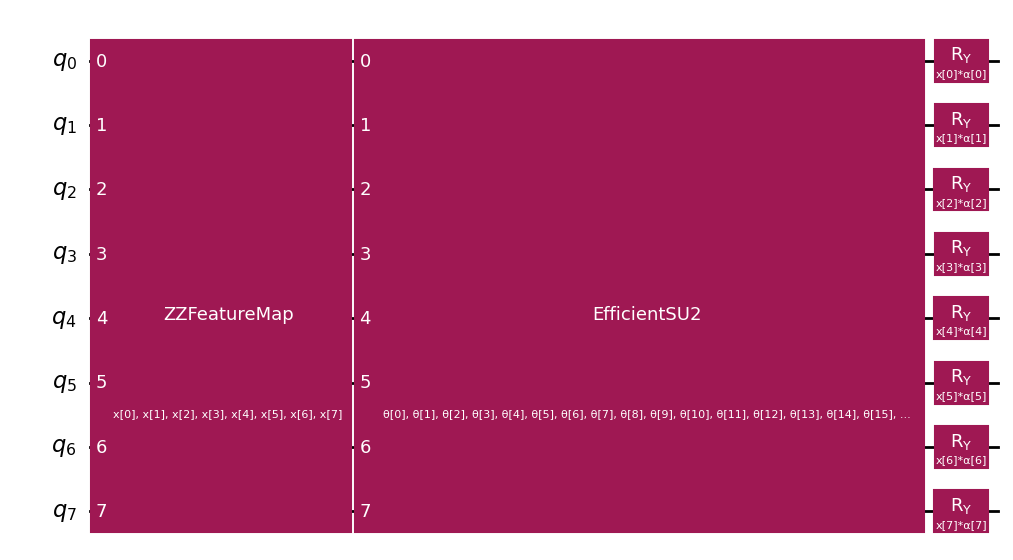

In [8]:
var_feature_map.draw(output='mpl')

Feature params: 8 | Trainable params: 48 | Total params: 56


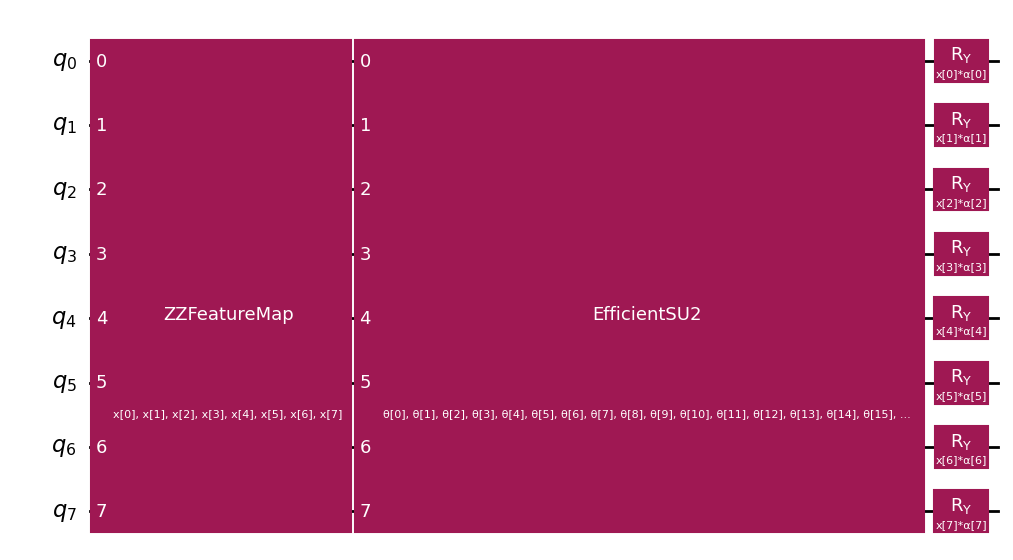

In [12]:
def build_composed_circuit(num_qubits):
    feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='linear', parameter_prefix='x')
    var_layer = EfficientSU2(num_qubits=num_qubits, su2_gates=['ry'], entanglement='linear', reps=4, insert_barriers=True, parameter_prefix='θ')
    alpha = ParameterVector('α', num_qubits)
    alpha_layer = QuantumCircuit(num_qubits)
    fm_params = list(feature_map.parameters)
    for i in range(num_qubits):
        alpha_layer.ry(alpha[i] * fm_params[i], i)
    var_feature_map = QuantumCircuit(num_qubits)
    var_feature_map.compose(feature_map, inplace=True)
    var_feature_map.compose(var_layer, inplace=True)
    var_feature_map.compose(alpha_layer, inplace=True)
    feature_params = list(feature_map.parameters)
    trainable_params = list(var_layer.parameters) + list(alpha)
    return feature_map, var_layer, alpha_layer, var_feature_map, feature_params, trainable_params

# Build circuit
feature_map, var_layer, alpha_layer, var_feature_map, feature_params, trainable_params = build_composed_circuit(num_qubits)
print(f"Feature params: {len(feature_params)} | Trainable params: {len(trainable_params)} | Total params: {len(var_feature_map.parameters)}")

# Draw circuit
var_feature_map.draw('mpl', filename='circuit.png')

In [9]:
init_p = 0.25 * np.random.uniform(-np.pi, np.pi, len(trainable_params))
print("Initial theta (init_p):", init_p)

Initial theta (init_p): [-0.68848743  0.45483058 -0.54051018  0.20315136  0.46025494 -0.30335648
 -0.37995965 -0.28202507  0.25332912  0.50422986 -0.02977484 -0.15866696
  0.7721852   0.49107108  0.73684985 -0.44495024 -0.41823563 -0.13442159
  0.39486967 -0.12897643  0.48697836  0.57865284  0.75350526  0.41907163
  0.67782205  0.58613742  0.64014412 -0.01728301 -0.66724758 -0.64973036
 -0.78466383  0.68158219 -0.41952724 -0.67861308 -0.33117912 -0.31530477
  0.26762839 -0.42103721  0.13644281 -0.19078486  0.39630677 -0.59523564
 -0.38174097 -0.69964874 -0.67516126  0.28810803 -0.66312744 -0.47822308]


In [ ]:
optimizers = ["SPSA"]
batch_sizes = [ 500]
sub_kernel_sizes = [ 500]
batch_types = [False, True]

In [13]:
callback, optimizer = get_optimizer_options("SPSA")
opt_instance = optimizer(callback=QKTCallback().callback)

In [ ]:
loss = BatchedSVCLoss(X_train, y_train_pegasos, minibatch_size=batch_size, sub_kernel_size=sub_kernel_size, balanced_batch=balanced_batch, shuffle=True)


In [ ]:
qk = TrainableFidelityStatevectorKernel(feature_map=var_feature_map, training_parameters=trainable_params)


In [ ]:
qkt = QuantumKernelTrainer(quantum_kernel=qk, loss=loss, optimizer=opt_instance, initial_point=init_p)
start = timer()
qka_results = qkt.fit(X_train, y_train_pegasos)
train_time = timer() - start
optimized_kernel = qka_results.quantum_kernel


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(loss.loss_arr, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Quantum Kernel Training')
plt.legend()
plt.grid(True)
plt.savefig('loss_curve.png')
plt.close()


In [ ]:
start = timer()
qsvc, auc, f1, accuracy = run_PegasosQSVC(X_train, y_train_pegasos, X_test, y_test_pegasos, optimized_kernel)
qsvc_runtime = timer() - start


In [ ]:
preds = qsvc.predict(X_test)
precision = precision_score(y_test_pegasos, preds, average="binary", zero_division=0)
recall = recall_score(y_test_pegasos, preds, average="binary", zero_division=0)
print(f"F1: {f1:.4f} | AUC: {auc:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
print(f"Kernel training time: {train_time:.2f}s | QSVC training time: {qsvc_runtime:.2f}s")